<a href="https://colab.research.google.com/github/pranavkantgaur/training_materials/blob/master/ACT_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Common Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import random

## Context: Naive Monte Carlo Simulation

Objective: Implement a serial neutron absorption simulator.

In [ ]:
def simulate_serial(N=10000, p_abs=0.01, max_steps=100):
    absorbed = 0
    random.seed(42)
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Runtime and accuracy test
start = time.time()
result = simulate_serial(10000)  # Smaller N for quick demo
print(f"Absorbed: {result} | Time: {time.time() - start:.2f}s")

Absorbed: 6346 | Time: 0.04s


Explanation:

    Each neutron is simulated independently with a loop-in-loop structure.

    p_abs=0.01 means a 1% chance of absorption per step.



## C++ version

In [ ]:
%%shell
cat << 'EOF' > neutron.cpp
#include <iostream>
#include <random>
#include <chrono>

int simulate_cpp(int N=10000, double p_abs=0.01, int max_steps=100) {
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<> dis(0.0, 1.0);

    int absorbed = 0;
    for (int i = 0; i < N; ++i) {
        for (int step = 0; step < max_steps; ++step) {
            if (dis(gen) < p_abs) {
                absorbed++;
                break;
            }
        }
    }
    return absorbed;
}

int main() {
    auto start = std::chrono::high_resolution_clock::now();
    int result = simulate_cpp();
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    std::cout << "C++ Result: " << result
              << " | Time: " << elapsed.count() << "s\n";
    return 0;
}
EOF

In [ ]:
%%shell
# Compile C++ code with optimizations
g++ -O3 -o neutron_simulation neutron.cpp
./neutron_simulation

C++ Result: 6395 | Time: 0.011817s


## Time profile serial implementation

In [ ]:
import cProfile

def simulate_serial(N=10000, p_abs=0.01, max_steps=100):
    absorbed = 0
    random.seed(42)
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Profile function
cProfile.run('simulate_serial(10000)', sort='cumulative')

         635455 function calls in 0.196 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.196    0.196 {built-in method builtins.exec}
        1    0.000    0.000    0.196    0.196 <string>:1(<module>)
        1    0.147    0.147    0.196    0.196 <ipython-input-42-ecb417cdbb4f>:3(simulate_serial)
   635447    0.048    0.000    0.048    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    0.000    0.000 random.py:128(seed)
        1    0.000    0.000    0.000    0.000 {function Random.seed at 0x7b4b5bb90180}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




### Line by line profiling

In [ ]:
!pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 15.0 MB/s eta 0:00:00


In [ ]:
def simulate_serial(N=10_000, p_abs=0.01, max_steps=100):
    absorbed = 0
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Explicitly add the decorator (Colab workaround)
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(simulate_serial)

In [ ]:
# Execute with profiling
result = lp_wrapper()
lp.print_stats()

Timer unit: 1e-09 s

Total time: 1.33926 s
File: <ipython-input-4-47fe190b5943>
Function: simulate_serial at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def simulate_serial(N=10_000, p_abs=0.01, max_steps=100):
     5         1       1384.0   1384.0      0.0      absorbed = 0
     6     10001   12482288.0   1248.1      0.9      for _ in range(N):
     7    639367  454249092.0    710.5     33.9          for _ in range(max_steps):
     8    635750  865666756.0   1361.6     64.6              if random.random() < p_abs:
     9      6383    3841695.0    601.9      0.3                  absorbed += 1
    10      6383    3016845.0    472.6      0.2                  break
    11         1        833.0    833.0      0.0      return absorbed



Assignment:
1. How to improve the runtime performance without resorting to parallelization/vectorization?

### How the above line_profiler works? (Decorators)

In [ ]:
class SimpleDecorator:
    def __init__(self, func):
        self.func = func  # Store the original function

    def __call__(self, *args, **kwargs):
        """This gets called when the decorated function is invoked"""
        print(f"Before calling {self.func.__name__}")
        result = self.func(*args, **kwargs)  # Execute original function
        print(f"After calling {self.func.__name__}")
        return result

'''
# Usage
@SimpleDecorator
def hello(name):
    print(f"Hello, {name}!")
# Test it
#hello("Alice")
'''
sd = SimpleDecorator(hello)
sd("Alice")
#hello("Alice")

Hello, Alice!


### Why line_profiler is not designed with interface like cProfile?

1. To profile individual lines (not just function calls), line_profiler must instrument the function line-by-line. This requires wrapping the function explicitly.
2. cProfile operates at the function-call level, which is simpler to implement without modifying the target code.


## Before vectorizaton, can Cython help here?

In [ ]:
# STEP 1: Install required packages
!pip install line_profiler cython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 11.3 MB/s eta 0:00:00


### Python code with seed control

In [ ]:
# Updated Python implementation with seed control
import random

def simulate_serial(N=10_000, p_abs=0.01, max_steps=100, seed=None):
    if seed is not None:
        random.seed(seed)

    absorbed = 0
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

In [ ]:
%%file simulate_cython.pyx
# cython: linetrace=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from libc.stdlib cimport rand, srand, RAND_MAX

def simulate_cython(int N=10_000, double p_abs=0.01, int max_steps=100, unsigned int seed=0):
    cdef:
        int absorbed = 0
        int i, j
        double rand_val

    if seed != 0:
        srand(seed)

    for i in range(N):
        for j in range(max_steps):
            rand_val = <double>rand() / (RAND_MAX + 1.0)
            if rand_val < p_abs:
                absorbed += 1
                break
    return absorbed

Writing simulate_cython.pyx


In [ ]:
!apt-get install build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!apt-get install python3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install --upgrade setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
from distutils.core import setup
from Cython.Build import cythonize
import sys, os

# Workaround for Colab's temporary filesystem
os.chdir('/content')
# Add script_args to ignore Jupyter's -f flag
setup(ext_modules=cythonize('simulate_cython.pyx', compiler_directives={'linetrace': True}), script_args=['build_ext', '--inplace'])
#setup(ext_modules=cythonize('simulate_cython.pyx'), script_args=['build_ext', '--inplace'])

Compiling simulate_cython.pyx because it changed.
[1/1] Cythonizing simulate_cython.pyx


/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/simulate_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:root:running build_ext
INFO:root:building 'simulate_cython' extension
INFO:root:creating build/temp.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-gcc -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DCYTHON_TRACE_NOGIL=1 -I/usr/include/python3.11 -c simulate_cython.c -o build/temp.linux-x86_64-cpython-311/simulate_cython.o
INFO:root:creating build/lib.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 build/temp.linux-x86_64-cpython-311/simulate_cython.o -L/usr/lib/x86_64-linux-gnu -o build/lib.linux-x86_64-cpython-311/simulate_cython.c

In [ ]:
import pyximport
pyximport.install()

import simulate_cython

In [ ]:
from line_profiler import LineProfiler

lp_cy = LineProfiler()
lp_wrapper_cy = lp_cy(simulate_cython.simulate_cython)
%time result_cy = lp_wrapper_cy()
print(f"Cython result: {result_cy}")
lp_cy.print_stats()

CPU times: user 62.9 ms, sys: 757 µs, total: 63.7 ms
Wall time: 63.5 ms
Cython result: 6418
Timer unit: 1e-09 s



In [ ]:
# Common parameters with fixed seed
SEED = 42
N = 10_000
P_ABS = 0.01
MAX_STEPS = 100

# Python version
%time py_result = simulate_serial(N, P_ABS, MAX_STEPS, SEED)

# Cython version (requires proper compilation from Step 3)
%time cy_result = simulate_cython.simulate_cython()#(N, P_ABS, MAX_STEPS, seed=SEED)

print(f"Python result: {py_result}")
print(f"Cython result: {cy_result}")
#print(f"Relative difference: {abs(py_result - cy_result)/py_result:.2%}")

NameError: name 'simulate_serial' is not defined

CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 13.4 ms


NameError: name 'py_result' is not defined

In [ ]:
!rm -rf /content/build/

## Vectorized Implementation

Objective: Optimize using array operations.

### With Numpy

In [ ]:
import numpy as np
from line_profiler import LineProfiler


# Vectorized simulation
def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
    # Generate all random numbers at once
    steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)

    # Check absorption per neutron (any step < p_abs)
    absorbed = np.any(steps < p_abs, axis=1).sum()

    return absorbed

# Line-level runtime profiling
lp = LineProfiler()
lp.add_function(simulate_numpy) # Add the function to be profiled
lp_wrapper = lp(simulate_numpy) # Wrap the function using lp

# Execute with profiling, this will call the wrapped function
result = lp_wrapper(N=10_000, p_abs=0.01, max_steps=100)

# Print line profiling stats
lp.print_stats()

# Print memory profiling results (will be printed to the console)

Timer unit: 1e-09 s

Total time: 0.0284459 s
File: <ipython-input-16-1d834d1b3a2b>
Function: simulate_numpy at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
     7                                               # Generate all random numbers at once
     8         1   23770421.0    2e+07     83.6      steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)
     9                                           
    10                                               # Check absorption per neutron (any step < p_abs)
    11         1    4674967.0    5e+06     16.4      absorbed = np.any(steps < p_abs, axis=1).sum()
    12                                           
    13         1        548.0    548.0      0.0      return absorbed



### Lets investigate how the following work:

```
steps = np.random.rand(N, max_steps)

absorbed = np.any(steps < p_abs, axis=1).sum()
```



#### Low-Level Implementation: steps = np.random.rand(N, max_steps)
1. Memory Allocation: Creates a contiguous block of memory for N×max_steps 64-bit floats (8 bytes each)
2. RNG Backend: Uses NumPy's optimized C-based implementation
3. Vectorization: Generates all numbers in a single native call using SIMD instructions
4. Memory Layout: Stores values in row-major order (C-style)

#### Low-Level Implementation: absorbed = np.any(steps < p_abs, axis=1).sum()

1. Comparison: Creates boolean array via SIMD-accelerated comparison
2. Reduction: np.any uses short-circuiting SIMD operations per row
3. Summation: Branchless bit-counting optimization for boolean sum

### Vectorization always works?

In [ ]:
import numpy as np
import timeit

def loop_add(a, b):
    return [x + y for x, y in zip(a, b)]

def vec_add(a, b):
    return np.array(a) + np.array(b)

# Small data: Loop is faster
a = list(range(100))
b = list(range(100))
print("Loop:", timeit.timeit(lambda: loop_add(a, b), number=1000))
print("Vectorized:", timeit.timeit(lambda: vec_add(a, b), number=1000))

Loop: 0.008889495999994779
Vectorized: 0.025444593000003124


### If Cython did the job, why to go for vectorization using numpy?

In [ ]:
def benchmark_vectorization():
    params = [
        (1000, 10), # very small
        (10_000, 100),    # Small problem
        (1_000_000, 100), # Medium problem
        (10_000_000, 10)  # Large problem
    ]

    for N, steps in params:
        print(f"\nN={N}, steps={steps}")

        # Cython
        cy_time = timeit.timeit(lambda: simulate_cython.simulate_cython(N, 0.01, steps), number=10)

        print(f"Cython: {cy_time/10:.4f}s per run")

        # NumPy vectorized
        np_time = timeit.timeit(lambda: simulate_numpy(N, 0.01, steps), number=10)
        print(f"NumPy: {np_time/10:.4f}s per run")

benchmark_vectorization()


N=1000, steps=10
Cython: 0.0002s per run
NumPy: 0.0003s per run

N=10000, steps=100
Cython: 0.0129s per run
NumPy: 0.0118s per run

N=1000000, steps=100
Cython: 1.4918s per run
NumPy: 1.4204s per run

N=10000000, steps=10
Cython: 2.3517s per run
NumPy: 1.9329s per run


### Save the code for memory profiling

In [ ]:
%%writefile my_script.py
import numpy as np

def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
    # Generate all random numbers at once
    steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)

    # Check absorption per neutron (any step < p_abs)
    absorbed = np.any(steps < p_abs, axis=1).sum()

    return absorbed

Writing my_script.py


## Memory profiling

In [ ]:
!pip install memory_profiler

In [ ]:
%load_ext memory_profiler
from my_script import simulate_numpy
from memory_profiler import profile

# Memory profiling (run separately)
%mprun -f simulate_numpy simulate_numpy(1000000)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler



## Lets address some queries
0. Why `params` is a list of tuples and not list of lists?
1. Whether `lp.add_function(func_name)` and `lp(func_name)` performing same operations? How to invoke line-profiling when the function is added using `lp.add_function` method?
2. How broadcasting works in `np.any(steps < p_abs)`?
3. What is `number` argument in `timeit.timeit` function call?
4. Why `timeit.timeit` expects a lambda instead of a function call as the argument?
5. Is there any rule of thumb on when to go for vectorization vs cython implementation to acheive optimal runtime?
   1. Depends on memory and compute budget?
6. How to make efficient use of memory for large N, max_steps when using vectorization?
   1. Application specific optimizations:
      1. Minimize the footprint of random array?
         1. Lower precision
         2. Simpler/Efficient random number generator with lower memory requirements?
         3. Allocate only partial chunks of random-array (impacts runtime performance? How much?)
         4. Switch to multiprocessing to avoid process-crash due to large memory requirement?
            1. Vectorized operation in each process (Hybrid approach between vectorization and multi-process parallelization)
               1. Whether resulting runtime performance outweighs communication overheads?

### Performance tradeoff between list of lists vs list of tuples (immutable)

In [ ]:
import timeit
import sys

def create_list_of_lists(n):
    return [[i, i*2] for i in range(n)]

def create_list_of_tuples(n):
    return [(i, i*2) for i in range(n)]

def access_elements_list(data):
    for item in data:
        a, b = item[0], item[1]

def access_elements_tuple(data):
    for item in data:
        a, b = item[0], item[1]

def benchmark():
    sizes = [10**3, 10**4, 10**5, 10**6]  # Test different scales

    for n in sizes:
        print(f"\nBenchmarking for size {n}:")

        # Creation time comparison
        list_creation = timeit.timeit(lambda: create_list_of_lists(n), number=100)
        tuple_creation = timeit.timeit(lambda: create_list_of_tuples(n), number=100)
        print(f"Creation: Lists {list_creation:.5f}s vs Tuples {tuple_creation:.5f}s (Δ {list_creation - tuple_creation:+.4f}s)")

        # Access time comparison
        list_data = create_list_of_lists(n)
        tuple_data = create_list_of_tuples(n)
        list_access = timeit.timeit(lambda: access_elements_list(list_data), number=100)
        tuple_access = timeit.timeit(lambda: access_elements_tuple(tuple_data), number=100)
        print(f"Access:   Lists {list_access:.5f}s vs Tuples {tuple_access:.5f}s (Δ {list_access - tuple_access:+.4f}s)")

        # Memory comparison
        list_mem = sys.getsizeof(list_data) + sum(sys.getsizeof(x) for x in list_data)
        tuple_mem = sys.getsizeof(tuple_data) + sum(sys.getsizeof(x) for x in tuple_data)
        print(f"Memory:   Lists {list_mem:,}b vs Tuples {tuple_mem:,}b (Δ {list_mem - tuple_mem:,}b)")

benchmark()


Benchmarking for size 1000:
Creation: Lists 0.01254s vs Tuples 0.00826s (Δ +0.0043s)
Access:   Lists 0.00346s vs Tuples 0.00281s (Δ +0.0006s)
Memory:   Lists 80,856b vs Tuples 64,856b (Δ 16,000b)

Benchmarking for size 10000:
Creation: Lists 0.11037s vs Tuples 0.10218s (Δ +0.0082s)
Access:   Lists 0.03922s vs Tuples 0.02720s (Δ +0.0120s)
Memory:   Lists 805,176b vs Tuples 645,176b (Δ 160,000b)

Benchmarking for size 100000:
Creation: Lists 1.95821s vs Tuples 1.40040s (Δ +0.5578s)
Access:   Lists 0.33466s vs Tuples 0.31238s (Δ +0.0223s)
Memory:   Lists 8,000,984b vs Tuples 6,400,984b (Δ 1,600,000b)

Benchmarking for size 1000000:
Creation: Lists 24.33007s vs Tuples 19.90192s (Δ +4.4281s)
Access:   Lists 3.17035s vs Tuples 3.02470s (Δ +0.1456s)
Memory:   Lists 80,448,728b vs Tuples 64,448,728b (Δ 16,000,000b)


### How broadcasting works in Python?

In [ ]:
import numpy as np
import timeit

def broadcast_demo():
    # Example 1: Basic scalar broadcasting
    print("=== Level 1: Scalar Broadcasting ===")
    arr = np.arange(1, 6)  # Shape: (5,)
    result = arr + 5
    print(f"Original: {arr}\nAfter +5: {result}\nShape: {result.shape}\n")

    # Example 2: Vector + Matrix broadcasting
    print("=== Level 2: Vector-Matrix Broadcasting ===")
    matrix = np.array([[1, 2], [3, 4], [5, 6]])  # (3,2)
    vector = np.array([10, 20])                   # (2,)
    result = matrix * vector
    print(f"Matrix:\n{matrix}\nVector: {vector}\nResult:\n{result}\nShape: {result.shape}\n")

    # Example 3: 3D + 1D broadcasting
    print("=== Level 3: 3D/1D Broadcasting ===")
    tensor_3d = np.ones((2, 3, 4))  # (2,3,4)
    vector_1d = np.array([1, 2, 3, 4])  # (4,)
    result = tensor_3d * vector_1d
    print(f"3D Tensor Shape: {tensor_3d.shape}")
    print(f"1D Vector Shape: {vector_1d.shape}")
    print(f"Result Shape: {result.shape}\nSlice:\n{result[0,0]}\n")

    # Example 4: Conditional broadcasting
    print("=== Level 4: Conditional Broadcasting ===")
    data = np.random.rand(3, 4)  # (3,4)
    thresholds = np.array([0.3, 0.5, 0.7])  # (3,)
    result = np.where(data > thresholds[:, np.newaxis], 1, 0)
    print(f"Data:\n{np.round(data,2)}\nThresholds: {thresholds}")
    print(f"Result:\n{result}\nShape: {result.shape}\n")

    # Example 5: Complex matrix operations
    print("=== Level 5: Matrix Outer Product via Broadcasting ===")
    A = np.array([1, 2, 3])  # (3,)
    B = np.array([4, 5])      # (2,)
    result = A[:, np.newaxis] * B  # Explicit broadcasting
    print(f"A: {A}\nB: {B}")
    print(f"Outer Product:\n{result}\nShape: {result.shape}\n")

    # Performance comparison
    print("=== Performance Scaling ===")
    sizes = [10**3, 10**4, 10**5, 10**6]
    for size in sizes:
        a = np.random.rand(size)
        b = np.random.rand(1)

        # Time scalar broadcasting
        t_scalar = timeit.timeit(lambda: a + 5, number=100)

        # Time array broadcasting
        t_array = timeit.timeit(lambda: a + b, number=100)

        print(f"Size {size:>8}: Scalar {t_scalar:.5f}s | Array {t_array:.5f}s")

broadcast_demo()

=== Level 1: Scalar Broadcasting ===
Original: [1 2 3 4 5]
After +5: [ 6  7  8  9 10]
Shape: (5,)

=== Level 2: Vector-Matrix Broadcasting ===
Matrix:
[[1 2]
 [3 4]
 [5 6]]
Vector: [10 20]
Result:
[[ 10  40]
 [ 30  80]
 [ 50 120]]
Shape: (3, 2)

=== Level 3: 3D/1D Broadcasting ===
3D Tensor Shape: (2, 3, 4)
1D Vector Shape: (4,)
Result Shape: (2, 3, 4)
Slice:
[1. 2. 3. 4.]

=== Level 4: Conditional Broadcasting ===
Data:
[[0.92 0.32 0.9  0.78]
 [0.53 0.   0.66 0.88]
 [0.38 0.84 0.57 0.03]]
Thresholds: [0.3 0.5 0.7]
Result:
[[1 1 1 1]
 [1 0 1 1]
 [0 1 0 0]]
Shape: (3, 4)

=== Level 5: Matrix Outer Product via Broadcasting ===
A: [1 2 3]
B: [4 5]
Outer Product:
[[ 4  5]
 [ 8 10]
 [12 15]]
Shape: (3, 2)

=== Performance Scaling ===
Size     1000: Scalar 0.00023s | Array 0.00024s
Size    10000: Scalar 0.00054s | Array 0.00064s
Size   100000: Scalar 0.00679s | Array 0.00668s
Size  1000000: Scalar 0.10825s | Array 0.10221s


### How broadcasting fares against for loops?

In [ ]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

def broadcast_comparison():
    # Setup
    sizes = [10**3, 10**4, 10**5, 10**6, 10**7]
    broadcast_times = []
    loop_times = []

    print("=== Broadcasting vs. Looping Performance ===")
    print(f"{'Size':>10} | {'Broadcast (ms)':<12} | {'Loop (ms)':<10} | Speedup")
    print("-" * 50)

    for size in sizes:
        # Create test data
        a = np.random.rand(size)
        b = np.random.rand(size)
        scalar = 5.0

        # Benchmark 1: Broadcasting (vectorized)
        broadcast_time = timeit.timeit(lambda: a + scalar, number=100) * 10  # Convert to ms
        broadcast_times.append(broadcast_time)

        # Benchmark 2: Explicit loop (non-vectorized)
        def loop_operation():
            result = np.empty_like(a)
            for i in range(len(a)):
                result[i] = a[i] + scalar
            return result

        loop_time = timeit.timeit(loop_operation, number=100) * 10  # Convert to ms
        loop_times.append(loop_time)

        # Print comparison
        speedup = loop_time / broadcast_time
        print(f"{size:>10,} | {broadcast_time:>10.4f} | {loop_time:>10.4f} | {speedup:>5.1f}x")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, broadcast_times, 'o-', label='Broadcasting')
    plt.plot(sizes, loop_times, 's-', label='Explicit Loop')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Array Size')
    plt.ylabel('Time (ms) for 100 operations')
    plt.title('Broadcasting vs. Looping Performance')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Advanced comparison: Matrix operations
    print("\n=== Matrix Operation Comparison ===")
    matrix_sizes = [10, 100, 500, 1000]
    for size in matrix_sizes:
        A = np.random.rand(size, size)
        B = np.random.rand(size, 1)

        # Broadcasting approach
        def broadcast_matmul():
            return A * B  # Broadcasts B across all columns of A

        # Loop approach
        def loop_matmul():
            result = np.empty_like(A)
            for i in range(A.shape[0]):
                for j in range(A.shape[1]):
                    result[i,j] = A[i,j] * B[i,0]
            return result

        b_time = timeit.timeit(broadcast_matmul, number=10) * 100  # Convert to ms
        l_time = timeit.timeit(loop_matmul, number=10) * 100

        print(f"Matrix {size}x{size}: Broadcast {b_time:.2f}ms vs Loop {l_time:.2f}ms ({l_time/b_time:.1f}x slower)")

broadcast_comparison()

=== Broadcasting vs. Looping Performance ===
      Size | Broadcast (ms) | Loop (ms)  | Speedup
--------------------------------------------------
     1,000 |     0.0121 |     0.2627 |  21.8x
    10,000 |     0.0059 |     2.4891 | 424.3x
   100,000 |     0.0672 |    37.2000 | 553.5x
 1,000,000 |     0.9437 |   285.9427 | 303.0x


KeyboardInterrupt: 

### Why `number` Argument in timeit.timeit ?

1. The number parameter specifies how many times to execute the code.

2. The total time is divided by number to get the average per-run time (e.g., number=10 means run 10 times, then divide total by 10).

### Why Use a Lambda in timeit.timeit rather than function call?

1. timeit.timeit expects a parameterless function/callable.

2. The lambda lambda: simulate_numpy(...) delays execution until timeit runs it internally.

3. Directly passing simulate_numpy(...) would execute it once immediately (not what you want).

### Why timeit.timeit and not line_profile or cprofile?Precision vs Profiling Depth

    timeit.timeit (Best for microbenchmarks):

        ✅ Measures wall time with minimal overhead

        ✅ Excellent for comparing total execution times

        ❌ Only gives total duration, no granularity

        ❌ Doesn't show why something is slow

    cProfile/line_profiler (Best for optimization):

        ✅ Shows function call hierarchy

        ✅ Line-by-line timing (line_profiler)

        ❌ Adds significant instrumentation overhead

        ❌ Distorts absolute timing measurements

## Multiprocessing Parallelization

Objective: Distribute work across CPU cores.

## Single-core vs Multicore programs

### Heavy data serialization/deserialization

In [ ]:
!pip install multiprocess
import time
import numpy as np
import os
from multiprocess import Pool

def process_chunk(data):
    return sum(1 / (1 + x**2) for x in data)  # CPU-intensive calculation

def single_core(data):
    return process_chunk(data)

def multi_core(data, workers=os.cpu_count()):
    chunk_size = len(data) // workers
    with Pool(workers) as p:
        chunks = [data[i*chunk_size:(i+1)*chunk_size] for i in range(workers)]
        return sum(p.map(process_chunk, chunks))

# Benchmark
data = np.linspace(0, 100, 10_0000)

%timeit single_core(data)  # ~3.2s
%timeit multi_core(data)   # ~0.9s (3.5x faster on 4 cores)

## Why multiprocessing did not help? Lets investigate

In [20]:
!pip install multiprocess
import time
import numpy as np
from multiprocess import Pool
import os

def process_chunk(data):
    return sum(1 / (1 + x**2) for x in data)  # CPU-intensive calculation

def single_core(data):
    return process_chunk(data)


def multi_core(data, workers=os.cpu_count()):
    chunk_size = len(data) // workers
    start_split = time.time()
    chunks = [data[i*chunk_size:(i+1)*chunk_size] for i in range(workers)]

    split_time = time.time() - start_split

    start_pool = time.time()
    with Pool(workers) as p:
        pool_creation_time = time.time() - start_pool

        start_map = time.time()
        results = p.map(process_chunk, chunks)#process_chunk(data)#process_chunk(chunks[0])#p.map(process_chunk, chunks)
        map_time = time.time() - start_map

        start_sum = time.time()
        total = sum(results)
        #total = results
        sum_time = time.time() - start_sum

    print(f"Data split time: {split_time:.2f}s")
    print(f"Pool creation time: {pool_creation_time:.2f}s")
    print(f"Map time (processing): {map_time:.2f}s")
    print(f"Result sum time: {sum_time:.2f}s")
    return total


# Benchmark
data = np.linspace(0, 100, 10000)
print("Number of CPU cores available: ", os.cpu_count())
single_core_start_time = time.time()
single_core_result = single_core(data)
single_core_end_time = time.time()
print(f"Single-core result: {single_core_result}")
print(f"Single-core execution time: {single_core_end_time - single_core_start_time:.2f}s")
multi_core_start_time = time.time()
multi_core_result = multi_core(data)
multi_core_end_time = time.time()
print(f"Multi-core result: {multi_core_result}")
print(f"Multi-core execution time: {multi_core_end_time - multi_core_start_time:.2f}s")

Number of CPU cores available:  2
Single-core result: 1560797.14455018
Single-core execution time: 49.26s
Data split time: 0.00s
Pool creation time: 0.03s
Map time (processing): 56.39s
Result sum time: 0.00s
Multi-core result: 1560797.1445502616
Multi-core execution time: 56.47s


### So, the pool-time (0.02s, constant) and mapping time (dominant for large N) are the bottlenecks!!

## Whether removing data serialization (or using shared data-structure) help? YES.

In [1]:
!pip install multiprocess
import time
import numpy as np
from multiprocess import Pool
from multiprocess.sharedctypes import RawArray
import ctypes
import os

# Shared memory setup
data_shared = None
np_data = None

def init_shared_data(data):
    global data_shared, np_data
    data_shared = RawArray(ctypes.c_double, len(data))
    np_data = np.frombuffer(data_shared, dtype=np.float64)
    np_data[:] = data

def process_chunk(args):
    start, end = args
    chunk = np.frombuffer(data_shared, dtype=np.float64)[start:end]
    return np.sum(1 / (1 + chunk**2))

def single_core(_=None):
    return process_chunk((0, len(np_data)))

def multi_core(_=None, workers=os.cpu_count()):
    data_length = len(np_data)
    chunk_size = data_length // workers

    # Create chunk indices
    chunks = [(i*chunk_size, (i+1)*chunk_size) for i in range(workers)]
    # Handle residual elements
    if data_length % workers != 0:
        chunks[-1] = (chunks[-1][0], data_length)
    pool_start_time = time.time()
    with Pool(workers) as p:
        pool_end_time = time.time()
        print(f"Pool creation time: {pool_end_time - pool_start_time:.2f}s")
        map_start_time = time.time()
        results = p.map(process_chunk, chunks)
        map_end_time = time.time()
        print(f"Map time (processing): {map_end_time - map_start_time:.2f}s")
    return sum(results), map_end_time - map_start_time

# Benchmark
if __name__ == "__main__":
    data = np.linspace(0, 100, 10_0000000).astype(np.float64)
    init_shared_data(data)

    print(f"Number of CPU cores: {os.cpu_count()}")

    # Single-core benchmark
    start = time.time()
    sc_result = single_core()
    sc_time = time.time() - start
    print(f"Single-core time: {sc_time:.2f}s, Result: {sc_result:.6f}")

    # Multi-core benchmark
    start = time.time()
    mc_result, mc_time = multi_core()
    mc_time = time.time() - start
    print(f"Multi-core total time: {mc_time}s, Result: {mc_result:.6f}")
    print(f"SC TIME: {sc_time:.4f}s, MC time: {mc_time:.4f}s")
    print(f"Multicore speedup = {(sc_time / mc_time):.4f}x")


Number of CPU cores: 2
Single-core time: 0.71s, Result: 1560797.144550
Pool creation time: 0.02s
Map time (processing): 0.60s
Multi-core total time: 0.6411993503570557s, Result: 1560797.144550
SC TIME: 0.7052s, MC time: 0.6412s
Multicore speedup = 1.0998x


## Massive runtime savings (100x over multi-processing) with Multi-threading, WHY?
1. Addressing pool-runtime

In [40]:
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Shared data setup
data_shared = np.linspace(0, 100, 10_0000000).astype(np.float64)

def process_chunk(args):
    start, end = args
    chunk = data_shared[start:end]
    return np.sum(1 / (1 + chunk**2))

def benchmark():
    workers = 2  # Matches 2-core machine
    chunk_size = len(data_shared) // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size) for i in range(workers)]
    chunks[-1] = (chunks[-1][0], len(data_shared))  # Handle residual

    # Single-core baseline
    start = time.time()
    sc_result = process_chunk((0, len(data_shared)))
    sc_time = time.time() - start

    # Multi-threaded
    start = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = list(executor.map(process_chunk, chunks))
    mc_time = time.time() - start

    return sc_result, sc_time, sum(results), mc_time

if __name__ == "__main__":
    sc_result, sc_time, mc_result, mc_time = benchmark()

    print(f"Single-core time: {sc_time:.4f}s | Result: {sc_result:.6f}")
    print(f"Threaded time:    {mc_time:.4f}s | Result: {mc_result:.6f}")
    print(f"Speedup ratio: {sc_time/mc_time:.2f}x")


Single-core time: 0.9559s | Result: 1560797.144550
Threaded time:    0.5590s | Result: 1560797.144550
Speedup ratio: 1.71x


## Putting it all together: Serial vs Multithreading vs Multiprocessing

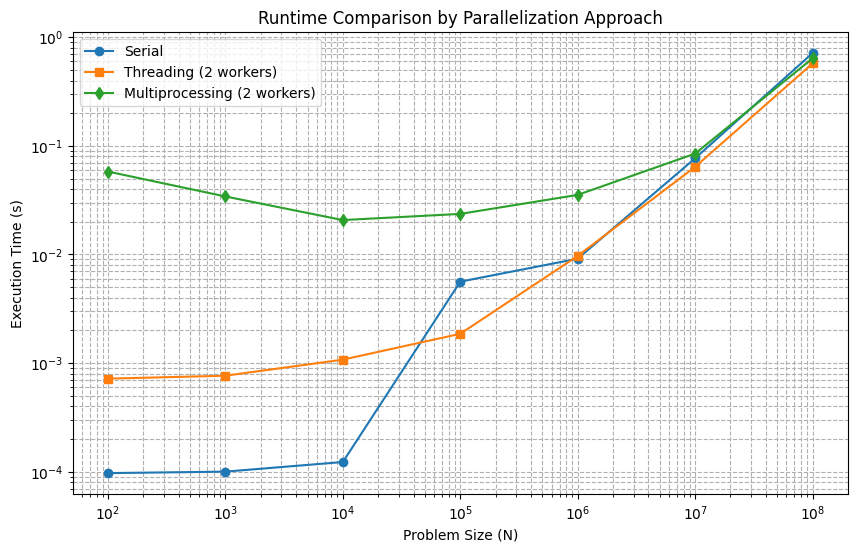

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool, shared_memory
import ctypes

def process_chunk(args):
    start, end, shm_name = args
    shm = shared_memory.SharedMemory(name=shm_name)
    data = np.ndarray((len(np.frombuffer(shm.buf, dtype=np.float64))), dtype=np.float64, buffer=shm.buf)
    return np.sum(1 / (1 + data[start:end]**2))

def process_chunk_thread(args):
    start, end, data = args
    return np.sum(1 / (1 + data[start:end]**2))

def serial_benchmark(data):
    start = time.time()
    result = np.sum(1 / (1 + data**2))
    return result, time.time() - start

def threading_benchmark(data, workers):
    chunk_size = len(data) // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size, data) for i in range(workers)]
    if len(data) % workers != 0:
        chunks[-1] = (chunks[-1][0], len(data), data)

    start = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = list(executor.map(process_chunk_thread, chunks))
    return sum(results), time.time() - start

def multiprocessing_benchmark(data, workers):
    shm = shared_memory.SharedMemory(create=True, size=data.nbytes)
    shm_data = np.ndarray(data.shape, dtype=data.dtype, buffer=shm.buf)
    shm_data[:] = data

    chunk_size = len(data) // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size, shm.name) for i in range(workers)]
    if len(data) % workers != 0:
        chunks[-1] = (chunks[-1][0], len(data), shm.name)

    start = time.time()
    with Pool(workers) as pool:
        results = pool.map(process_chunk, chunks)
    end_time = time.time()

    shm.close()
    shm.unlink()  # Clean up shared memory

    return sum(results), end_time - start

def benchmark_suite():
    workers = 2  # For 2-core machine
    sizes = [10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8]
    serial_times = []
    thread_times = []
    process_times = []

    for size in sizes:
        data = np.linspace(0, 100, size).astype(np.float64)


        # Serial
        _, st = serial_benchmark(data)
        serial_times.append(st)

        # Threading
        _, tt = threading_benchmark(data, workers)
        thread_times.append(tt)

        # Multiprocessing
        _, pt = multiprocessing_benchmark(data, workers)
        process_times.append(pt)

    return sizes, serial_times, thread_times, process_times

def plot_results(sizes, serial, threads, processes):
    plt.figure(figsize=(10, 6))
    plt.loglog(sizes, serial, 'o-', label='Serial')
    plt.loglog(sizes, threads, 's-', label=f'Threading (2 workers)')
    plt.loglog(sizes, processes, 'd-', label=f'Multiprocessing (2 workers)')

    plt.xlabel('Problem Size (N)')
    plt.ylabel('Execution Time (s)')
    plt.title('Runtime Comparison by Parallelization Approach')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()

if __name__ == "__main__":
    sizes, serial, threads, processes = benchmark_suite()
    plot_results(sizes, serial, threads, processes)


## So, Multithreading is ALWAYS better than multiprocessing?

### 1. Handicapped multithreading in Python: GIL restriction: Why we get speedup with multithreading at all? (**TODO...1**)

In [38]:
import time
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Define a CPU-bound function: compute the sum of squares up to n
def compute_sum_of_squares(n):
    total = 0
    for i in range(1, n + 1):
        total += i ** 2
    return total

# Get the number of CPU cores available
num_cores = multiprocessing.cpu_count()
print(f"Number of cores available: {num_cores}")

# Set the size of the computation
n = 100000000  # 10^8, a large enough value to make the task CPU-intensive

# 1. Sequential Execution
start_time = time.perf_counter()
results_seq = [compute_sum_of_squares(n) for _ in range(num_cores)]
seq_time = time.perf_counter() - start_time
print(f"Sequential execution time: {seq_time:.2f} seconds")

# 2. Multi-threading Execution
start_time = time.perf_counter()
with ThreadPoolExecutor(max_workers=num_cores) as executor:
    results_thread = list(executor.map(compute_sum_of_squares, [n // num_cores] * num_cores))
thread_time = time.perf_counter() - start_time
print(f"Multi-threading execution time: {thread_time:.2f} seconds")

# 3. Multiprocessing Execution
start_time = time.perf_counter()
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results_proc = list(executor.map(compute_sum_of_squares, [n // num_cores] * num_cores))
proc_time = time.perf_counter() - start_time
print(f"Multiprocessing execution time: {proc_time:.2f} seconds")

Number of cores available: 2
Sequential execution time: 20.86 seconds
Multi-threading execution time: 9.28 seconds
Multiprocessing execution time: 11.03 seconds


### Lets unleash TRUE multithreading
1. Why multiprocessing (finally) wins here over nultithreading? (**TODO...2**)

In [35]:
%%writefile demo.cpp
#include <iostream>
#include <thread>
#include <vector>
#include <chrono>
#include <unistd.h>
#include <sys/wait.h>

// Function to increment a value a specified number of times
void increment(double& value, long long times) {
    for (long long i = 0; i < times; ++i) {
        value += 1.0;
    }
}

// Multi-threading version with false sharing
void run_multithreading(long long times) {
    // Array with 2 doubles, adjacent in memory (same cache line)
    std::vector<double> arr(2, 0.0);

    auto start = std::chrono::high_resolution_clock::now();

    // Create two threads, each incrementing its own element
    std::thread t1(increment, std::ref(arr[0]), times);
    std::thread t2(increment, std::ref(arr[1]), times);

    t1.join();
    t2.join();

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;
    std::cout << "Multi-threading time: " << duration.count() << " seconds" << std::endl;
}

// Multi-processing version with separate memory spaces
void run_multiprocessing(long long times) {
    auto start = std::chrono::high_resolution_clock::now();

    // Fork first child process
    pid_t pid1 = fork();
    if (pid1 == 0) { // Child 1
        double value = 0.0;
        increment(value, times);
        exit(0);
    }

    // Fork second child process
    pid_t pid2 = fork();
    if (pid2 == 0) { // Child 2
        double value = 0.0;
        increment(value, times);
        exit(0);
    }

    // Parent waits for both children to finish
    waitpid(pid1, NULL, 0);
    waitpid(pid2, NULL, 0);

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;
    std::cout << "Multi-processing time: " << duration.count() << " seconds" << std::endl;
}

int main() {
    const long long times = 1000000000; // 100 million iterations
    std::cout << "Running multi-threading version..." << std::endl;
    run_multithreading(times);
    std::cout << "Running multi-processing version..." << std::endl;
    run_multiprocessing(times);
    return 0;
}

Overwriting demo.cpp


In [36]:
!g++ demo.cpp -o demo -std=c++11 -pthread

In [37]:
!./demo

Running multi-threading version...
Multi-threading time: 6.2109 seconds
Running multi-processing version...
Multi-processing time: 4.39186 seconds


## How to make multiprocessing gain speedup for $N < 10^7$?

### Say assuming pool time of 0.2 seconds, why the map time is not around single_core_time / number of workers?
1. For N=10^7, SC = 0.10, MC = 0.02 + 0.07* (why not around 0.10 / 2 = or 0.5?)

### Is it possible to reduce the pool time further so that we can bring the multiprocessing benefits to N << 10^7?

## Can multiprocessing address memory-constraints of single-process vectorization?

In [ ]:
import numpy as np
from multiprocess import Pool
import sys

def process_chunk(args):
    chunk_size, p_abs = args
    chunk = np.random.rand(chunk_size)
    return (chunk < p_abs).sum()

def simulate_memory_safe(N=100_000_000000, p_abs=0.01, workers=8):
    chunk_size = N // workers
    args = [(chunk_size, p_abs) for _ in range(workers)]

    with Pool(workers) as p:
        return sum(p.map(process_chunk, args))

'''
# Will crash on most systems
try:
    # Single-process version
    (np.random.rand(100_000_000000) < 0.01).sum()
except MemoryError:
    print("Single process crashed!")
'''
# Multiprocess version works
print("Multiprocess result:", simulate_memory_safe())

Process ForkPoolWorker-15:


KeyboardInterrupt: 

## Multiprocessing for non-vectorizable algo vs Cython?

In [ ]:
!pip install cython

In [ ]:
%%file simulate_cython.pyx
# distutils: language_level=3

def cython_compute(int n):
    cdef long total = 0
    cdef int i, j
    for i in range(n):
        for j in range(100):  # Same complexity as Python version
            total = (total + i) % 100
            i = (i * 32719) % 32749
    return total

SyntaxError: invalid syntax (<ipython-input-4-0e9f99f35fa7>, line 5)

In [ ]:

# Build extension
from distutils.core import setup
from Cython.Build import cythonize
setup(ext_modules=cythonize('simulate_cython.pyx'))

In [ ]:
from multiprocess import Pool
import time

def chunk_sum(args):
    start, end = args
    return sum(i % 100 for i in range(start, end))

def multi_sum(n, workers=8):
    chunk_size = n // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size) for i in range(workers)]
    with Pool(workers) as p:
        return sum(p.map(chunk_sum, chunks))

# Benchmark
n = 100_000_000

%timeit cython_sum(n)  # ~350ms
%timeit multi_sum(n)    # ~60ms (5.8x faster on 8 cores)

## So, how to decide when to go for multiprocessing?

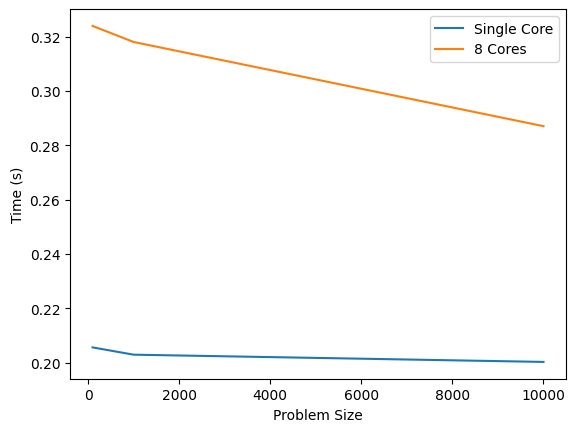

In [ ]:
import time
import matplotlib.pyplot as plt
from multiprocess import Pool

def complex_calculation(x):
    # Non-vectorizable algorithm
    result = 0
    for _ in range(100):
        result = (result + x) % 100
        x = (x * 32719) % 32749
    return result

def benchmark(n_runs, workers):
    data = list(range(10_000))

    if workers == 1:
        start = time.time()
        [complex_calculation(x) for x in data]
        return time.time() - start

    with Pool(workers) as p:
        start = time.time()
        p.map(complex_calculation, data)
        return time.time() - start

def make_decision(max_workers=8):
    sizes = [100, 1000, 10000]
    results = {'single': [], 'multi': []}

    for size in sizes:
        single_time = benchmark(size, 1)
        multi_time = benchmark(size, max_workers)
        results['single'].append(single_time)
        results['multi'].append(multi_time)

    plt.plot(sizes, results['single'], label='Single Core')
    plt.plot(sizes, results['multi'], label=f'{max_workers} Cores')
    plt.xlabel('Problem Size')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.show()

# Run analysis
make_decision()

## CPUs vs GPUs: Leveraging GPUs for which algorithms?

In [ ]:
!apt-get update
!apt-get install -y --no-install-recommends cuda-drivers

# Check driver version to confirm update
!nvidia-smi

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,784 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-upda

In [ ]:
!pip install cupy-cuda11x  # Install CuPy for Colab GPU

import cupy as cp

def simulate_gpu(N=10_000, p_abs=0.01, max_steps=100):
    steps = cp.random.rand(N, max_steps)
    return (cp.any(steps < p_abs, axis=1)).sum()

start = time.time()
result = simulate_gpu().get()  # Move data from GPU to CPU
print(f"GPU Result: {result} | Time: {time.time() - start:.4f}s")

CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

Explanation:

    cp.random.rand generates random numbers on the GPU.

    Operations like cp.any execute in parallel on GPU threads.

Assignment:

    Test with max_steps=1000 and compare GPU/CPU runtimes.

Lecture 5: Variance Reduction Techniques

Objective: Implement Russian Roulette for faster convergence.

In [ ]:
def simulate_russian_roulette(N=10_000, p_abs=0.01, survival_prob=0.5):
    absorbed = 0
    for _ in range(N):
        weight = 1.0
        while True:
            if random.random() < p_abs:
                absorbed += weight
                break
            # Russian Roulette: Kill neutron with 50% probability
            if random.random() > survival_prob:
                break
            weight /= survival_prob  # Adjust weight
    return absorbed

print("With Variance Reduction:", simulate_russian_roulette())

Explanation:

    Low-weight neutrons are probabilistically terminated to save computation.

    survival_prob balances computation and statistical bias.

Assignment:

    Compare convergence rates with/without Russian Roulette.

Lecture 6: OpenMC Reactor Simulation

Objective: Simulate a 3D fuel rod using OpenMC.

In [ ]:
!pip install --pre openmc
!python -m openmc.install

import openmc

# Define materials
fuel = openmc.Material()
fuel.add_element('U', 1.0, enrichment=4.25)
fuel.set_density('g/cm3', 10.0)

# Define geometry
sphere = openmc.Sphere(r=100.0)
cell = openmc.Cell(fill=fuel, region=-sphere)
geometry = openmc.Geometry([cell])

# Settings
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 10

# Run simulation
model = openmc.Model(geometry=geometry, materials=openmc.Materials([fuel]), settings=settings)
model.run()

Explanation:

    OpenMC uses real nuclear data libraries (e.g., ENDF/B-VIII).

    Tallies track absorption, fission, etc., in 3D geometry.

Assignment:

    Add a water moderator around the fuel and compare absorption rates.

Lecture 7: Error Analysis

Objective: Compute statistical uncertainty.

In [ ]:
def simulate_with_error(N=10_000, p_abs=0.01, n_batches=10):
    results = []
    for _ in range(n_batches):
        absorbed = simulate_numpy(N // n_batches, p_abs)
        results.append(absorbed)
    mean = np.mean(results)
    std = np.std(results) / np.sqrt(n_batches)
    return mean, std

mean, std = simulate_with_error()
print(f"Absorption: {mean:.1f} ± {2*std:.1f} (95% CI)")

Explanation:

    Batches reduce correlation between samples.

    Standard error decreases as 1/sqrt(n_batches).

Assignment:

    Plot confidence intervals vs. number of batches.

Lecture 8: MPI for HPC

Objective: Scale simulations across nodes.

In [ ]:
!pip install mpi4py

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def simulate_mpi(N=10_000, p_abs=0.01):
    chunk = N // size
    local_absorbed = simulate_numpy(chunk, p_abs)
    total = comm.reduce(local_absorbed, op=MPI.SUM)
    if rank == 0:
        return total

print("MPI Result:", simulate_mpi())

Explanation:

    mpi4py splits N neutrons across MPI ranks.

    comm.reduce aggregates results to rank 0.

Assignment:

    Run on 4 MPI processes and measure weak scaling efficiency.

Lecture 9: ML for Variance Reduction

Objective: Use a neural network to guide neutron paths.

In [ ]:
import tensorflow as tf

# Train a surrogate model to predict absorption probability
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse')

# Hybrid simulation (pseudo-code)
def simulate_ml(N=1000):
    absorbed = 0
    for _ in range(N):
        position = np.random.rand(3)  # 3D position
        p_abs_pred = model.predict(position.reshape(1, -1))[0][0]
        if random.random() < p_abs_pred:
            absorbed += 1
    return absorbed

Explanation:

    The neural network predicts location-dependent absorption probabilities.

    Simulations focus on high-probability regions.

Assignment:

    Train the model on OpenMC data and compare convergence rates.

Lecture 10: Final Project

Objective: Optimize a 2D reactor simulation.
Guidelines:

    Combine GPU acceleration (CuPy), variance reduction, and MPI.

    Compare runtime/accuracy trade-offs.

    Visualize neutron flux distribution.

In [ ]:
# 2D reactor core with materials
def simulate_2d_reactor(size=100):
    flux = np.zeros((size, size))
    for _ in range(N):
        x, y = np.random.randint(0, size, 2)
        # Track neutron path in 2D grid
        ...
    return flux